In [ ]:
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import matplotlib.pyplot as plt
import torch

def process_image(img):
    img = img.resize((200, 80), Image.LANCZOS)  # Fixed size
    img = img.convert('L')
    img = np.asarray(img)
    img = img / 255
    return img

In [ ]:
from skimage import feature
class OCRData(Dataset):
    def __init__(self, meta, base_dir):
        super().__init__()
        self.base_dir = base_dir
        self.read_data(meta)

    def read_data(self, path):
        self.img = []
        with open(path, 'r') as f:
            for line in f:
                file, _ = line.strip().split()
                img = process_image(Image.open(self.base_dir + file))
                self.img.append(torch.FloatTensor(img))

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        img = self.img[idx]
        return img

In [ ]:
data = OCRData('annote.txt','')

C:\Users\ALIENWARE\AppData\Local\Temp\ipykernel_23344\61721957.py:14: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_numpy.cpp:209.)
  self.img.append(torch.FloatTensor(img))


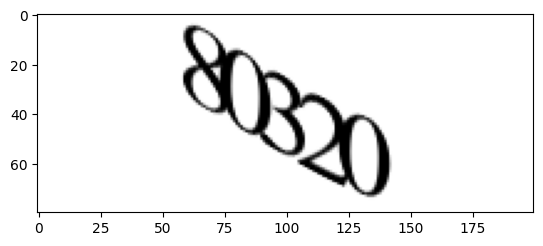

In [ ]:
plt.imshow(data[0], cmap='gray')

In [ ]:
import numpy as np
import cv2
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt

def estimate_warp_params(img_np):
    """
    Estimate amplitude, period, and phase of the sine wave distortion.
    Assumes vertical sine wave warping along x-axis.
    """
    h, w = img_np.shape[:2]
    gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)

    # Find vertical shifts by tracking edge peaks
    shifts = []
    for x in range(w):
        column = edges[:, x]
        peaks = np.where(column > 0)[0]  # y-coordinates of edges
        if len(peaks) > 1:  # Need at least two edges to estimate shift
            mid_y = np.median(peaks)
            shifts.append(mid_y - h / 2)  # Shift from image center
        else:
            shifts.append(0)

    shifts = np.array(shifts)
    x = np.arange(w)

    # Fit sine wave: y = a * sin(2πx/b + phase)
    from scipy.optimize import curve_fit
    def sine_func(x, a, b, phase):
        return a * np.sin(2 * np.pi * x / b + phase)
    
    p0 = [30.0, 50.0, 0.0]  # Initial guess: amplitude, period, phase
    try:
        popt, _ = curve_fit(sine_func, x, shifts, p0=p0, maxfev=5000)
        a_est, b_est, phase_est = popt
    except RuntimeError:
        # Fallback to default values if fitting fails
        a_est, b_est, phase_est = 30.0, 50.0, 0.0

    return a_est, b_est, phase_est

def dewarp_image(img_np):
    """
    General de-warping based on estimated sine wave parameters.
    """
    h, w = img_np.shape[:2]
    a, b, phase = estimate_warp_params(img_np)

    x, y = np.meshgrid(np.arange(w), np.arange(h))
    # Inverse shift: y' = y + a * sin(2πx/b + phase)
    y_shift = a * np.sin(2 * np.pi * x / b + phase)
    map_y = y + y_shift
    map_x = x

    dewarped = np.zeros_like(img_np)
    for c in range(img_np.shape[2]):
        dewarped[:, :, c] = map_coordinates(img_np[:, :, c], [map_y, map_x], order=1, mode='reflect')
    
    return dewarped.astype(np.uint8)

In [ ]:
def segment_image(self, img_np):
    # Visualize original and de-warped
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title("Original")
    plt.axis('off')

    dewarped_img = dewarp_image(img_np)
    plt.subplot(1, 2, 2)
    plt.imshow(dewarped_img)
    plt.title("Dewarped")
    plt.axis('off')
    plt.show()

    # Proceed with segmentation
    gray = cv2.cvtColor(dewarped_img, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    dist = cv2.distanceTransform(binary, cv2.DIST_L2, 5)
    _, fg = cv2.threshold(dist, 0.5 * dist.max(), 255, 0)  # Lower threshold for sensitivity
    fg = np.uint8(fg)
    unknown = cv2.subtract(cv2.dilate(binary, None), fg)
    _, markers = cv2.connectedComponents(fg)
    markers += 1
    markers[unknown == 255] = 0
    markers = cv2.watershed(dewarped_img, markers)
    binary[markers == -1] = 0

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = sorted([cv2.boundingRect(c) for c in contours if cv2.contourArea(c) > 50], key=lambda b: b[0])

    segments = []
    if len(boxes) < 1:
        for i in range(5):
            x_start = i * 40
            x_end = min((i + 1) * 40, 200)
            crop = dewarped_img[:, x_start:x_end, :]
            crop_img = Image.fromarray(crop).resize((40, 80), Image.LANCZOS)
            segments.append(crop_img)
    else:
        for x, y, w, h in boxes:
            crop = dewarped_img[:, max(0, x):min(200, x+w), :]
            crop_img = Image.fromarray(crop).resize((40, 80), Image.LANCZOS)
            segments.append(crop_img)
    
    while len(segments) < 5:
        i = len(segments)
        x_start = i * 40
        x_end = min((i + 1) * 40, 200)
        crop = dewarped_img[:, x_start:x_end, :]
        crop_img = Image.fromarray(crop).resize((40, 80), Image.LANCZOS)
        segments.append(crop_img)
    
    # Debug: Visualize segments
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    for ax, seg in zip(axes, segments):
        ax.imshow(np.array(seg))
        ax.axis('off')
    plt.show()
    
    return segments[:5]